# Forecasting metrics: case 3

In this notebooks forecast metrics for all models fitted for the simulation case 3 are calculated and saved to a single file.

In [1]:
import os
import sys
import pickle

import tensorflow as tf
import pandas as pd
import numpy as np

src_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(src_path)

from Metrics.metrics import get_model_metrics
from DataSimulation.utils import plot_fit
from Transformers.model import Forecaster


## Data

In [2]:
case="case_3"
case_path = os.path.join(src_path, "Notebooks", "data_generation_and_models_fitting", case)

In [3]:
data = pd.read_csv(os.path.join(case_path, 'data.csv'), header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,2.0,173.0,143.0,11.0,2.0,937.0,81.0,52.0,27.0,20.0
1,1.0,267.0,104.0,3.0,2.0,43.0,36.0,7.0,23.0,10.0
2,5.0,102.0,73.0,12.0,1.0,714.0,35.0,44.0,29.0,3.0
3,11.0,115.0,100.0,5.0,0.0,2662.0,15.0,38.0,22.0,10.0
4,0.0,73.0,137.0,9.0,0.0,1063.0,73.0,77.0,29.0,5.0


In [4]:
test_size = 4*24
train_data = data.iloc[:-test_size, :].to_numpy()
test_data = data.iloc[-test_size:, :].to_numpy()
num_vars = train_data.shape[-1]
print(train_data.shape)
print(test_data.shape)

(904, 10)
(96, 10)


In [5]:
metrics = {}
metrics_statistics = {}

## Sarima model

In [6]:
with open(os.path.join(case_path, "sarima.pkl"), "rb") as file:
    sarima_model = pickle.load(file)

In [7]:
sarima_prediction = sarima_model.predict(test_size)

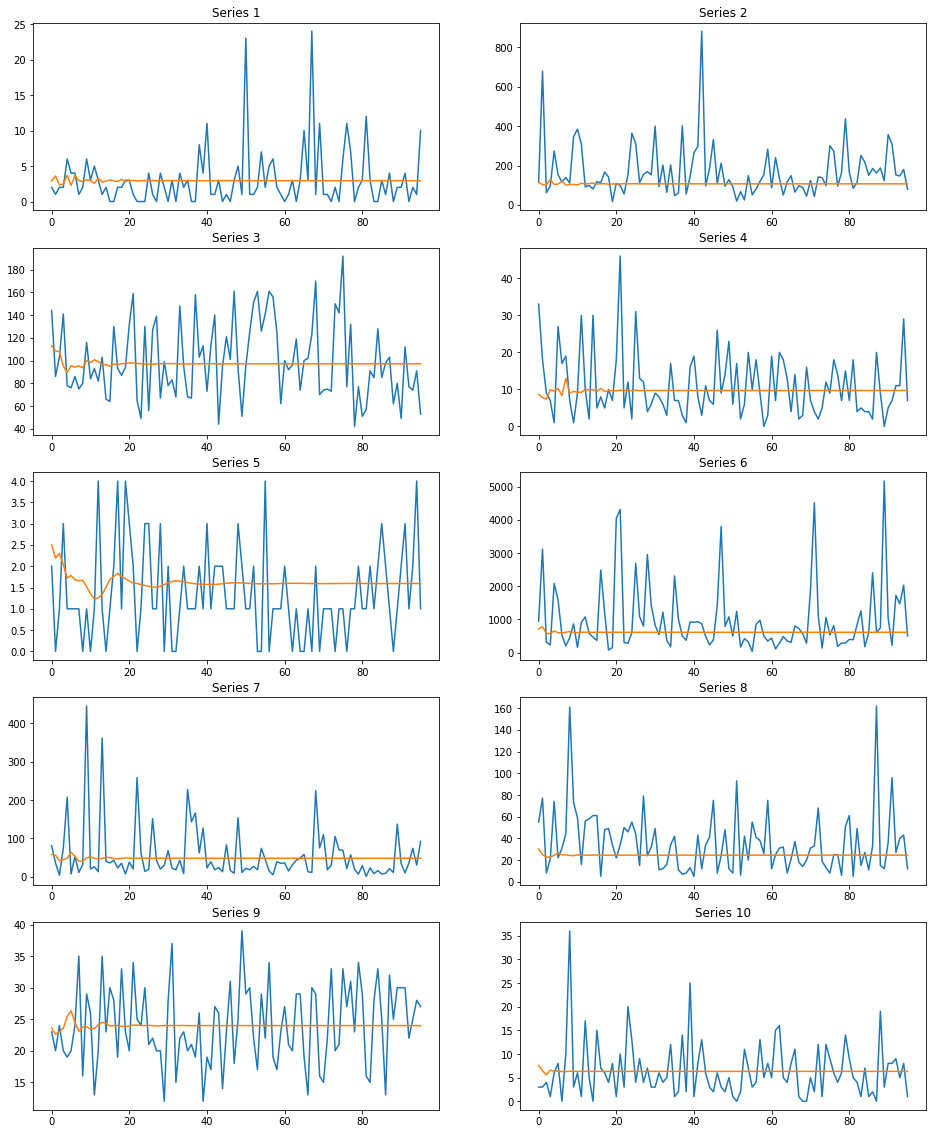

In [8]:
plot_fit(test_data, sarima_prediction, predicted=True, cols=2)

In [9]:
sarima_metrics, sarima_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=sarima_prediction,
    train_data=train_data,
    m=1,
    model_name="sarima",
    case=case
)
metrics.update(sarima_metrics)
metrics_statistics.update(sarima_statistics)

## Poisson Autoregression model

In [10]:
with open(os.path.join(case_path, "poisson_autoregression.pkl"), "rb") as file:
    poisson_ar_model = pickle.load(file)

In [11]:
poisson_ar_prediction = poisson_ar_model.predict(test_size)

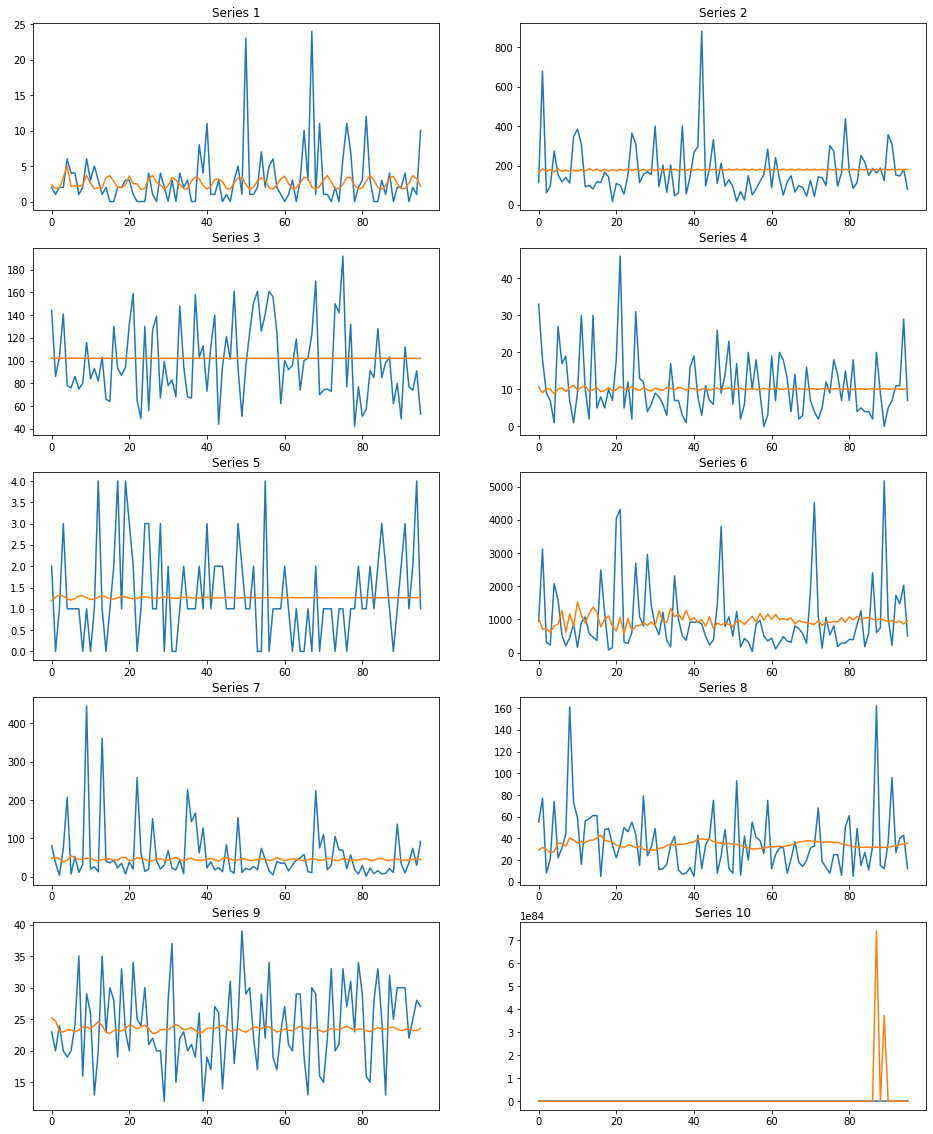

In [12]:
plot_fit(test_data, poisson_ar_prediction, predicted=True, cols=2)

In [13]:
p_ar_metrics, p_ar_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=poisson_ar_prediction,
    train_data=train_data,
    m=1,
    model_name="poisson_autorregression",
    case=case
)
metrics.update(p_ar_metrics)
metrics_statistics.update(p_ar_statistics)

In [14]:
p_ar_metrics, p_ar_statistics = get_model_metrics(
    test_data=test_data[:, :-1],
    predicted_values=poisson_ar_prediction[:,:-1],
    train_data=train_data[:,:-1],
    m=1,
    model_name="poisson_autorregression_adjusted",
    case=case
)
metrics.update(p_ar_metrics)
metrics_statistics.update(p_ar_statistics)

## Recurrent Neural Network

The model summary in the "rnn_fit.ipynb" allows to know that the best model uses a 24 timesteps input

In [15]:
input_steps = 24


In [16]:
with open(os.path.join(case_path, "rnn_scaler.pkl"), "rb") as file:
    rnn_scaler = pickle.load(file)

In [17]:
scaled_data = rnn_scaler.transform(train_data[-input_steps:]).reshape((1,input_steps,-1))

In [18]:
rnn_model = tf.keras.models.load_model(os.path.join(case_path, "rnn.h5"))

In [19]:
initial_prediction = rnn_model.predict(scaled_data)
current_prediction = initial_prediction
rnn_prediction = current_prediction
for _ in range(3):
    current_prediction = rnn_model.predict(current_prediction)
    rnn_prediction = np.concatenate([rnn_prediction, current_prediction], axis=0)

rnn_prediction = rnn_prediction.reshape((-1,num_vars))

1/1 [==============================] - 0s 27ms/step


In [20]:
rnn_prediction = rnn_scaler.inverse_transform(rnn_prediction)

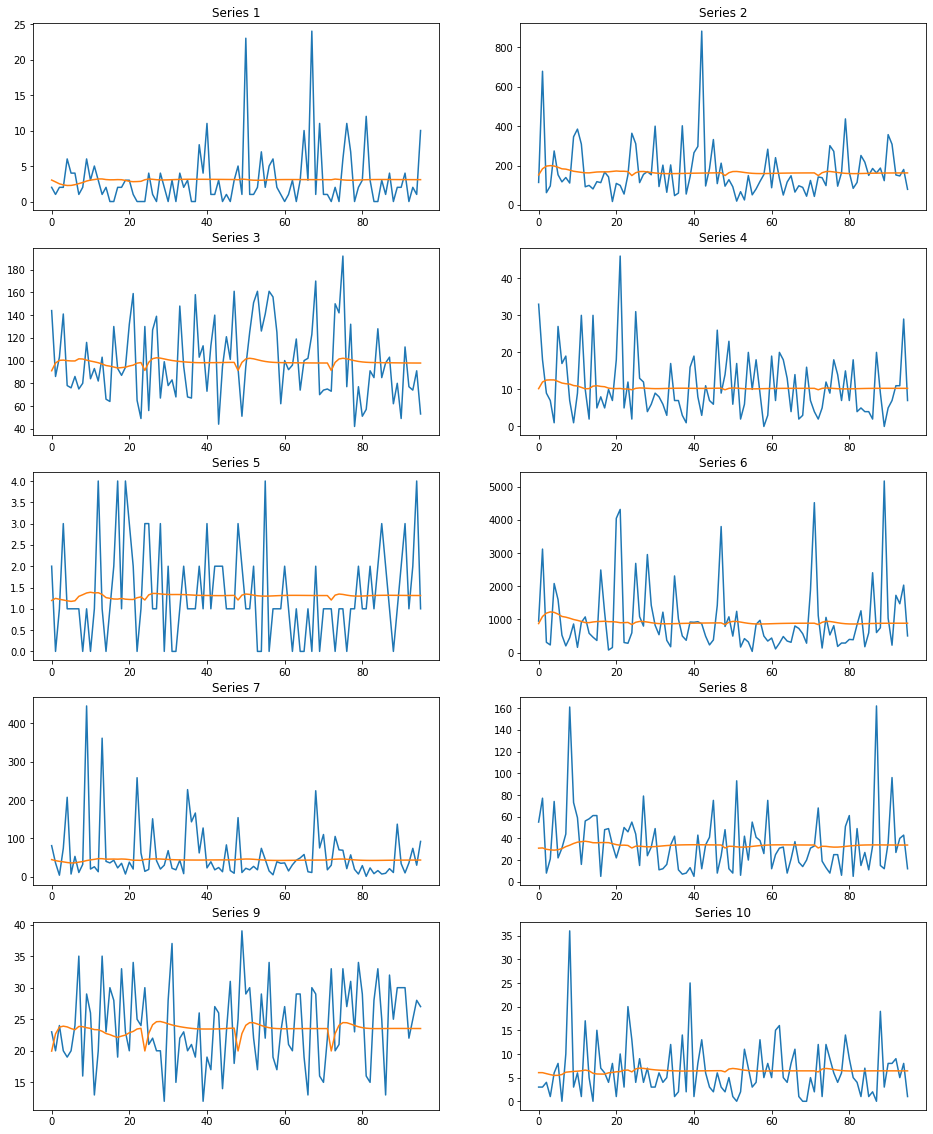

In [21]:
plot_fit(test_data, rnn_prediction, predicted=True, cols=2)

In [22]:
rnn_metrics, rnn_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=rnn_prediction,
    train_data=train_data,
    m=1,
    model_name="recurrent_neural_network",
    case=case
)
metrics.update(rnn_metrics)
metrics_statistics.update(rnn_statistics)

## Transformer model

In [23]:
with open(os.path.join(case_path, "transformer_scaler.pkl"), "rb") as file:
    transformer_scaler = pickle.load(file)

In [24]:
transformer_model = tf.keras.models.load_model(os.path.join(case_path, "transformer.tf"))

In [25]:
forecaster = Forecaster(transformer_scaler, transformer_model)

In [26]:
t_input_steps = 24
inputs = train_data[-t_input_steps:]

In [27]:
transformer_prediction = forecaster(inputs=inputs, steps=24)

In [28]:
inputs = train_data[-t_input_steps:]
initial_prediction = forecaster(inputs=inputs, steps=24)
current_prediction = initial_prediction
transformer_prediction = current_prediction
for _ in range(3):
    current_prediction =forecaster(inputs=current_prediction, steps=24)
    transformer_prediction = np.concatenate([transformer_prediction, current_prediction], axis=0)

In [29]:
transformer_prediction

array([[   2.5554085,  170.0392   ,   98.74257  ,   10.518402 ,
           1.3080227, 1056.3065   ,   48.084126 ,   30.994888 ,
          23.12818  ,    7.2546883],
       [   2.565866 ,  170.2196   ,   98.917656 ,   10.550342 ,
           1.3102925, 1048.0372   ,   48.158356 ,   30.996742 ,
          23.120598 ,    7.254058 ],
       [   2.5675645,  170.20088  ,   98.95603  ,   10.555866 ,
           1.3102977, 1047.4646   ,   48.186184 ,   30.998516 ,
          23.118229 ,    7.256478 ],
       [   2.5710366,  170.0224   ,   98.97739  ,   10.544417 ,
           1.3087094, 1046.1506   ,   48.143925 ,   31.031027 ,
          23.114006 ,    7.25288  ],
       [   2.5735955,  169.79912  ,   98.96743  ,   10.525906 ,
           1.3067567, 1045.1533   ,   48.081577 ,   31.071587 ,
          23.110056 ,    7.2468734],
       [   2.573492 ,  169.71315  ,   98.94073  ,   10.516472 ,
           1.3060274, 1044.9995   ,   48.055317 ,   31.086641 ,
          23.109354 ,    7.243356 ],
       [  

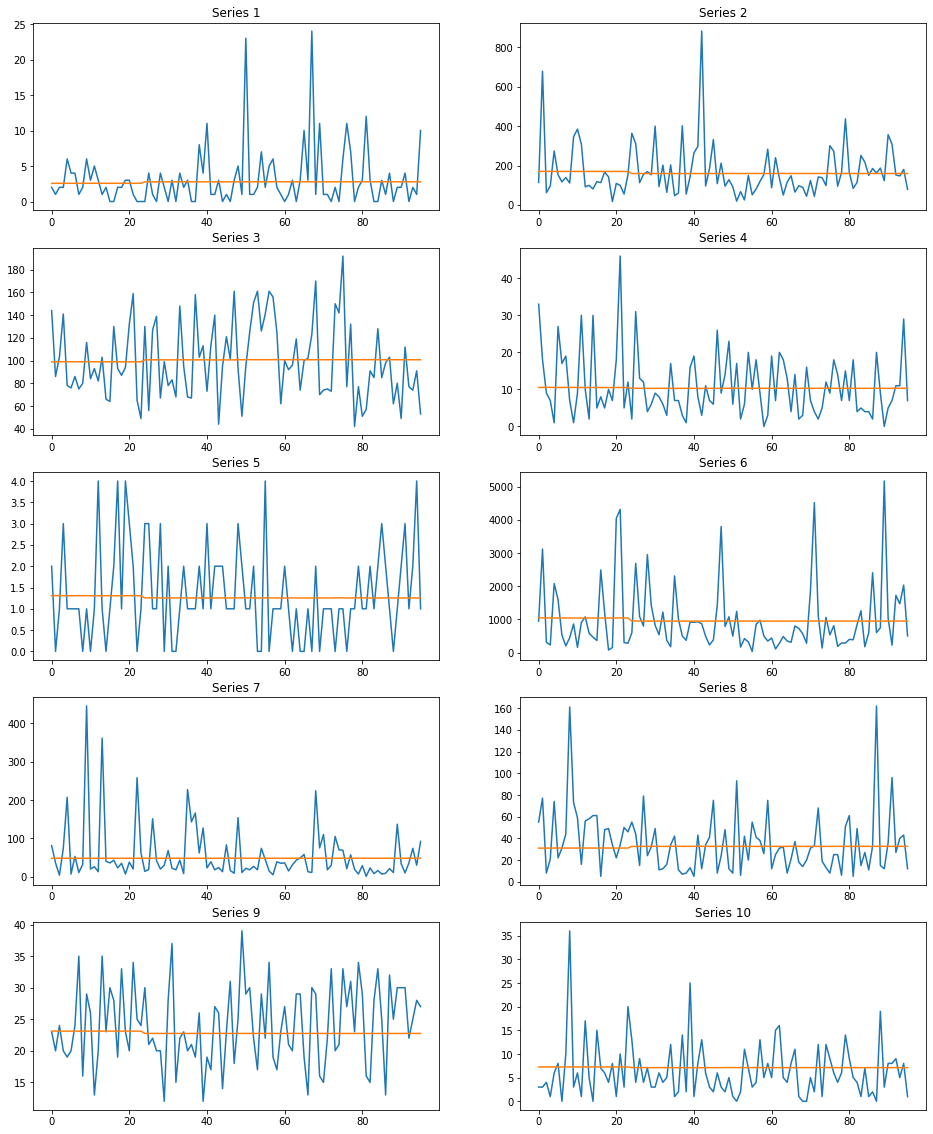

In [30]:
plot_fit(test_data, transformer_prediction, predicted=True, cols=2)

In [31]:
transformer_metrics, transformer_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=transformer_prediction,
    train_data=train_data,
    m=1,
    model_name="transformer",
    case=case
)
metrics.update(transformer_metrics)
metrics_statistics.update(transformer_statistics)

## Metrics results

In [33]:
pd.DataFrame(metrics_statistics)

sarima           poisson_autorregression                \
                 sMAPE      MASE                   sMAPE          MASE   
case_3 mean  60.652692  0.727742               70.514742  1.935832e+81   
       sd    20.311764  0.071630               37.571302  5.807495e+81   
       min   22.280465  0.641602               22.160651  6.227625e-01   
       max   89.040849  0.889162              166.224047  1.935832e+82   

            poisson_autorregression_adjusted            \
                                       sMAPE      MASE   
case_3 mean                        59.880374  0.736275   
       sd                          20.917692  0.085215   
       min                         22.160651  0.622762   
       max                         89.538716  0.870757   

            recurrent_neural_network           transformer            
                               sMAPE      MASE       sMAPE      MASE  
case_3 mean                60.410491  0.725579   60.837908  0.729259  
       sd                  20.079955  0.068853   20.404217  0.078333  
       min                 22.795603  0.637287   22.134574  0.624483  
       max                 89.853515  0.858322   89.484493  0.889738

In [34]:
with open("metrics.pkl", "wb") as outfile:
    pickle.dump(metrics, outfile)

with open("statistics.pkl", "wb") as outfile:
    pickle.dump(metrics_statistics, outfile)